## Chapter 14. Deep Computer Vision with CNNs
### 합성공 신경망을 사용한 컴퓨터 비전

In [11]:
# Setting
import sys
assert sys.version_info >= (3,5)

# scikit
import sklearn
assert sklearn.__version__ >= "0.20"

# tensorflow
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# common module
import numpy as np
import os

# consistency
np.random.seed(42)
tf.random.set_seed(42)

# Graph
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# Save pics
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout=True, fig_extension ="png", resolution = 300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)  # ( , , , , ) Error -> ( , , + + ) # BOOKMARK
    print("그림저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
# image in gray-scale or in color

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation ="nearest")
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image, interpolation = "nearest")
    plt.axis("off")

### 합성곱이란 무엇인가?

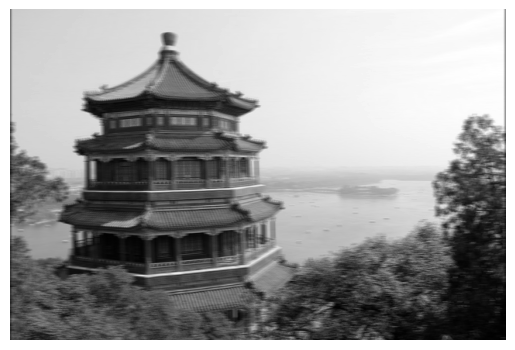

In [6]:
import numpy as np
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# filters
filters = np.zeros(shape = (7, 7, channels, 2), dtype = np.float32)
filters[:, 3, :, 0] = 1 # vertical
filters[3, : ,: ,1] = 1 # horizontal

outputs = tf.nn.conv2d(images, filters, strides =1, padding = "SAME")

plt.imshow(outputs[0, :, :, 1], cmap = "gray")
plt.axis("off")
plt.show()

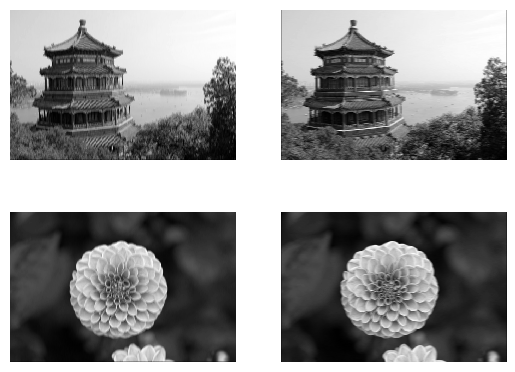

In [7]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index*2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [8]:
def crop(images):
    return images[150:220, 130:250]

그림저장 china_original


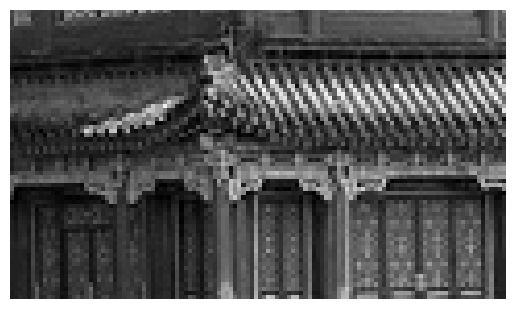

그림저장 china_vertical


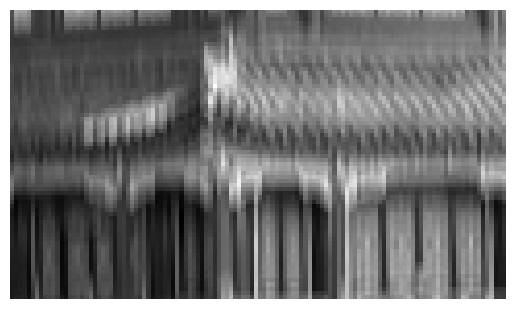

그림저장 china_horizontal


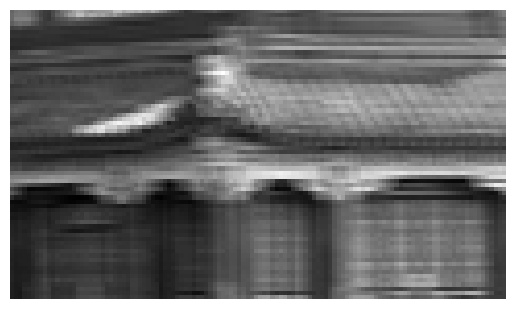

In [12]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout = False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout = False)
    plt.show()

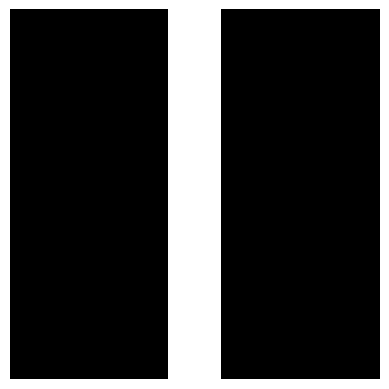

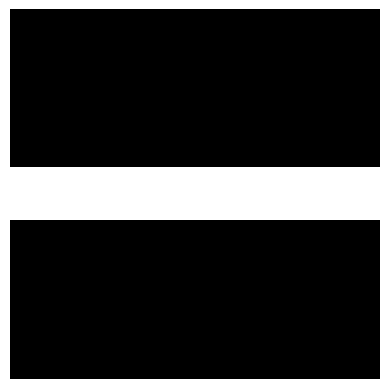

In [14]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [15]:
# 합성곱 층

np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size = 7, strides = 1,
                          padding = "SAME", activation = "relu", input_shape = outputs.shape)

In [16]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

In [ ]:
# 4D 텐서, 차원은 배치크기, 높이, 너비, 채널
# 배치크기: 2개의 이미지 입력, 2
# 출력 특성맵의 높이와 너비: padding = "SAME", strides = 1 -> 입력 이미지와 같다 -> 이경우 437x640
# 채널: 합성곱 층은 2개의 필터를 사용함 -> 입력 이미지 마다 2개의 특성맵이 출력된다

# 필터는 초기에 랜덥하게 초기화되기 때문에 처음에는 랜덤한 패턴을 감지한다

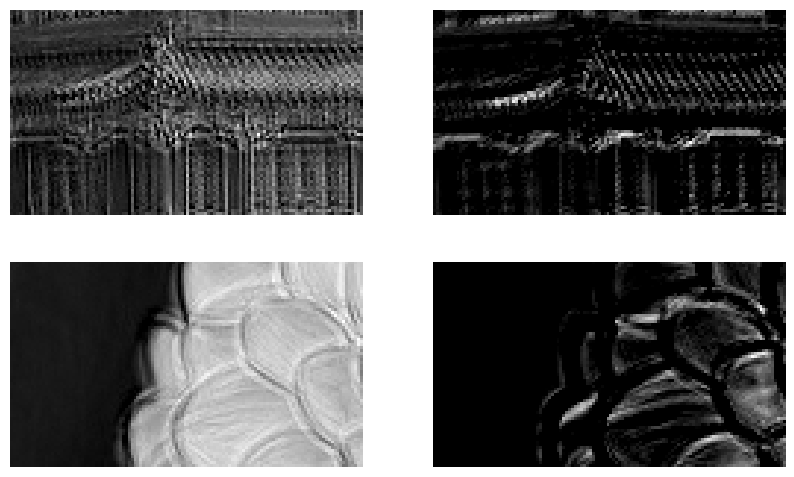

In [19]:
# 이미지 마다 2개의 특성맵 출력 

plt.figure(figsize = (10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index*2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [ ]:
# 피렅가 초기에 랜덤하게 초기화됨, 두 번째 필터는 에지를 감지한 것처럼 보임
# 원하면 필터를 앞에서 수동으로 정의한 필터를 사용하고 편향을 0으로 지정할 수 잇음 
# (합성곱층이 훈련하는 동안 적절한 필터와 편향 학습하므로 실제로는 수동으로 지정할 필요 없음)

In [20]:
conv.set_weights([filters, np.zeros(2)])

In [21]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

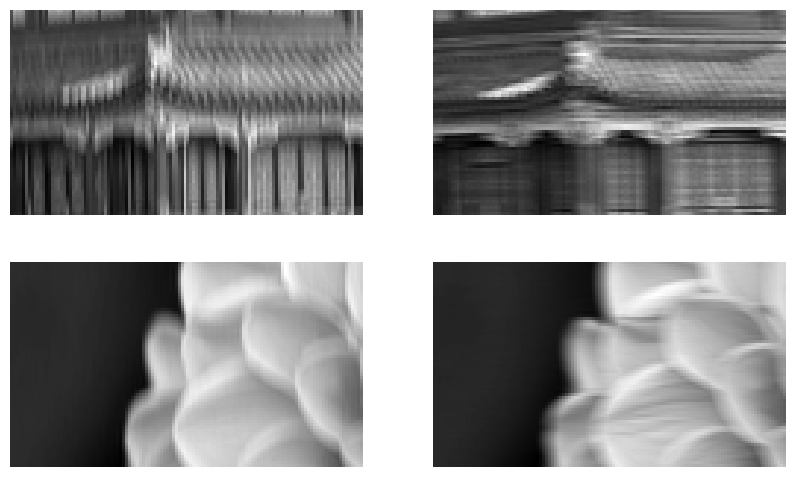

In [24]:
plt.figure(figsize = (10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index*2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [ ]:
# VALID vs SAME padding

In [26]:
def feature_map_size(input_size, kernel_size, strides = 1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1 # // floor division: Divide and take the floor number. (round the number down to the nearest integer) 
    else:
        return (input_size - kernel_size) // strides + 1

In [27]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size -1)*strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [36]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
            return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype = np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [39]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size = kernel_size, strides = strides, padding = "VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size = kernel_size, strides = strides, padding = "SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# conv_same 가중치 생성
conv_same.build(tf.TensorShape(images.shape))

# conv_valid의 가중치를 conv_smae으로 복사
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

In [41]:
# Pooling Layer

# Max_pool

max_pool = keras.layers.MaxPool2D(pool_size = 2)


In [43]:
cropped_images = np.array([crop(image) for image in images], dtype = np.float32)
output = max_pool(cropped_images)

그림저장 china_max_pooling


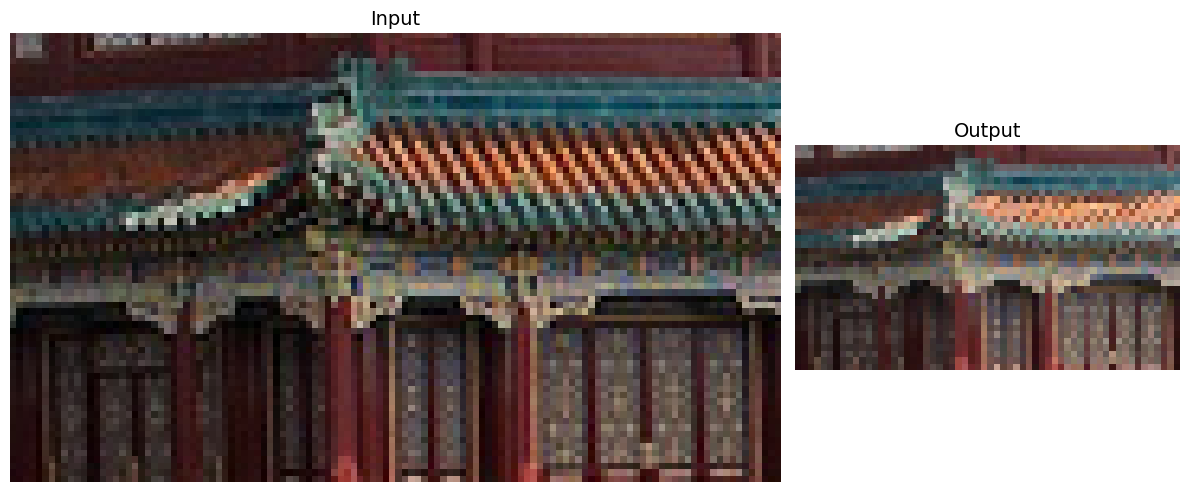

In [45]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows = 1, ncols = 2, width_ratios = [2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize = 14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize = 14)
ax2.imshow(output[0])
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

# axis("off") -> Remove axes, ticklabels
# https://frhyme.github.io/python-lib/plt_axis_off/

In [46]:
# Depth_wise Pooling 깊이 방향 풀링

class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides = None, padding = "VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                             ksize = (1, 1, 1, self.pool_size),
                             strides = (1, 1, 1, self.pool_size),
                             padding = self.padding)

In [47]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):  # 아직 GPU 커널이 없음
    depth_output = depth_pool(cropped_images)
depth_output.shape


TensorShape([2, 70, 120, 1])

In [48]:
# 또는 Lambda 층을 사용

depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
X, ksize = (1, 1, 1, 3), strides = (1, 1, 1, 3), padding = "VALID"))

with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

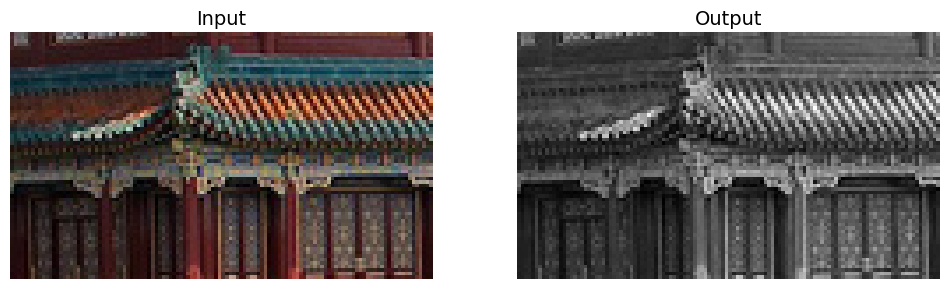

In [51]:
plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize = 14)
plot_color_image(cropped_images[0])
plt.subplot(1, 2, 2)
plt.title("Output", fontsize = 14)
plot_image(depth_output[0, ..., 0]) # 첫번째 이미지 출력 그리기
plt.axis("off")
plt.show()

In [52]:
# 평균 풀링

avg_pool = keras.layers.AvgPool2D(pool_size = 2)
output_avg = avg_pool(cropped_images)

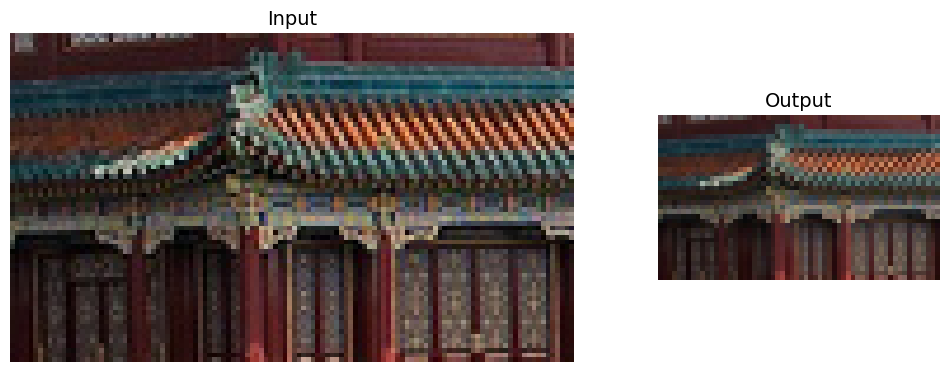

In [55]:
fig = plt.figure(figsize = (12, 8))
gs = mpl.gridspec.GridSpec(nrows = 1, ncols = 2,  width_ratios = [2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize = 14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize = 14)
ax2.imshow(output_avg[0])
ax2.axis("off")

plt.show()

In [56]:
# 전역 평균 풀링

global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

In [58]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis = [1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

### CNN 구조

In [ ]:
# keras로 간단한 CNN 모델 구현, MNIST 문제 

In [61]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims = True) +1e-7
X_train = (X_train - X_mean / X_std)
X_valid = (X_valid - X_mean / X_std)
X_test = (X_test - X_mean / X_std)

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [63]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size = 3, activation = "relu", padding = "SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters = 64, kernel_size = 7, input_shape = [28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size =2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size =2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size =2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [64]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 30s 16ms/step - loss: 0.7989 - accuracy: 0.7299 - val_loss: 0.4093 - val_accuracy: 0.8552
Epoch 2/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4729 - accuracy: 0.8395 - val_loss: 0.3866 - val_accuracy: 0.8632
Epoch 3/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4251 - accuracy: 0.8555 - val_loss: 0.3175 - val_accuracy: 0.8786
Epoch 4/10
1719/1719 [==============================] - 28s 16ms/step - loss: 0.3932 - accuracy: 0.8665 - val_loss: 0.3164 - val_accuracy: 0.8830
Epoch 5/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3823 - accuracy: 0.8672 - val_loss: 0.3132 - val_accuracy: 0.8846
Epoch 6/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3769 - accuracy: 0.8691 - val_loss: 0.2992 - val_accuracy: 0.8886
Epoch 7/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3646 - accuracy: 0.8737 - val_loss: 0.3050 -

### 케라스를 활용해 ResNet-34 CNN 구현하기

In [67]:
DecaultConv2D = partial(keras.layers.Conv2D, kernel_size = 3, strides = 1, padding = "SAME", use_bias = False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = "relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides = strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size = 1, strides = strides),
                keras.layers.BatchNormalization()
            ]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [69]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size = 7, strides=2, input_shape = [224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "SAME"))
prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filgers = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = "softmax"))

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74368     
 )                                                               
                                                      

### 케라스에서 제공하는 사전훈련된 모델 사용하기

In [71]:
# keras.applications packages provide standard models

model = keras.applications.resnet50.ResNet50(weights = "imagenet")

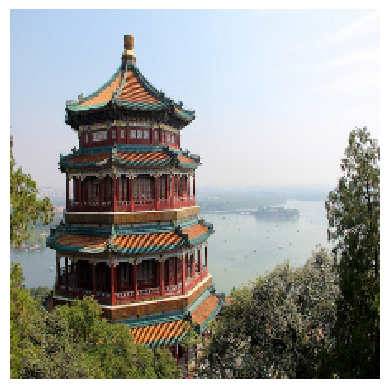

In [72]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])

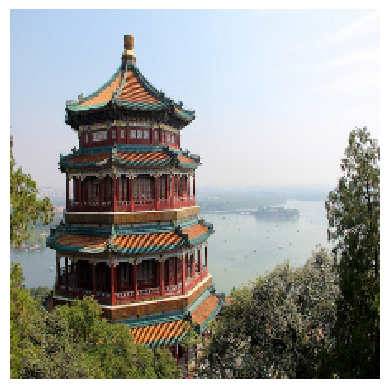

In [73]:
images_resized - tf.image.resize_with_pad(images, 224, 224, antialias = True)
plot_color_image(images_resized[0])
plt.show()

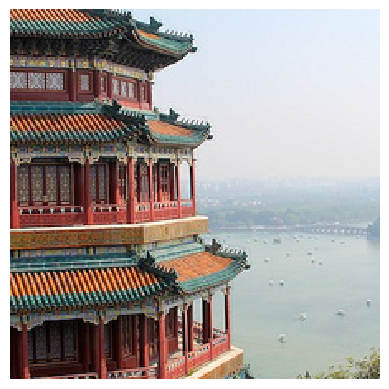

In [75]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

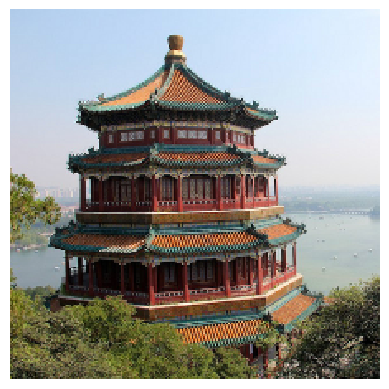

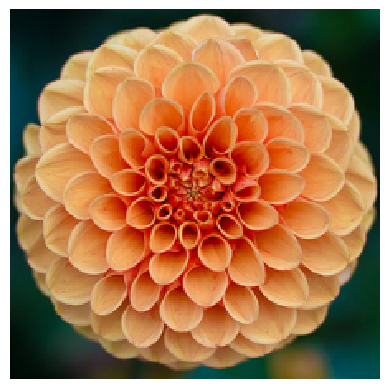

In [76]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [77]:
inputs = keras.applications.resnet50.preprocess_input(images_resized*255)
Y_proba = model.predict(inputs)

1/1 [==============================] - 1s 953ms/step


In [78]:
Y_proba.shape

(2, 1000)

In [79]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba*100))
    print()

35363/35363 [==============================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



### 사전훈련된 모델을 사용한 전이 학습

In [80]:
# 사전훈련된 모델 불러와 전이학슴: xception
# 최상층의 전역 평균 풀링 층과 밀집 출력 층을 include_top = False 로 제외시킴, 새로운 전역 풀링층과 출력층 추가

import tensorflow_datasets as tfds

datasets, info = tfds.load("tf_flowers", as_supervised = True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\jaeho\tensorflow_datasets\tf_flowers\3.0.1.incomplete9ODO9B\tf_flowers-train.tfrecord*...: …

Dataset tf_flowers downloaded and prepared to C:\Users\jaeho\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [81]:
info.splits

{Split('train'): <SplitInfo num_examples=3670, num_shards=2>}

In [83]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [84]:
class_names = info.features["label"].names
class_names                    

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [88]:
n_classes = info.features["label"].num_classes

In [90]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [91]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
"tf_flowers",
split = ["train[:10%]", "train[10%:25%]", "train[25%:]"],
as_supervised=True)

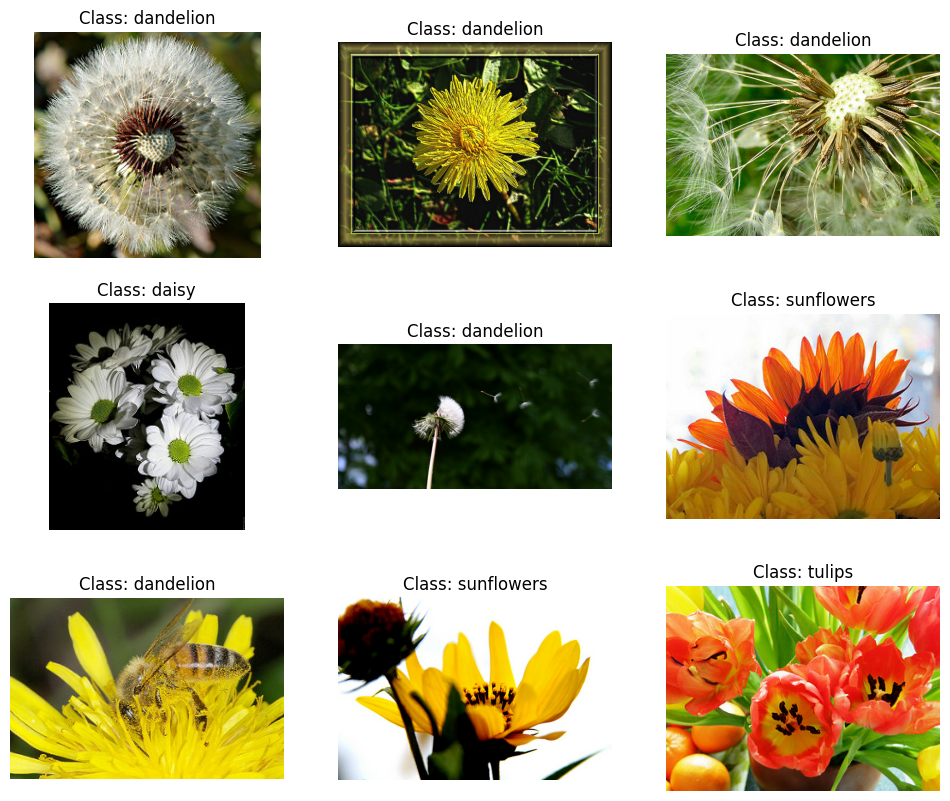

In [92]:
plt.figure(figsize = (12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

In [99]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])*90 // 100
    return tf.image.random_crop (image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize = False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize = True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

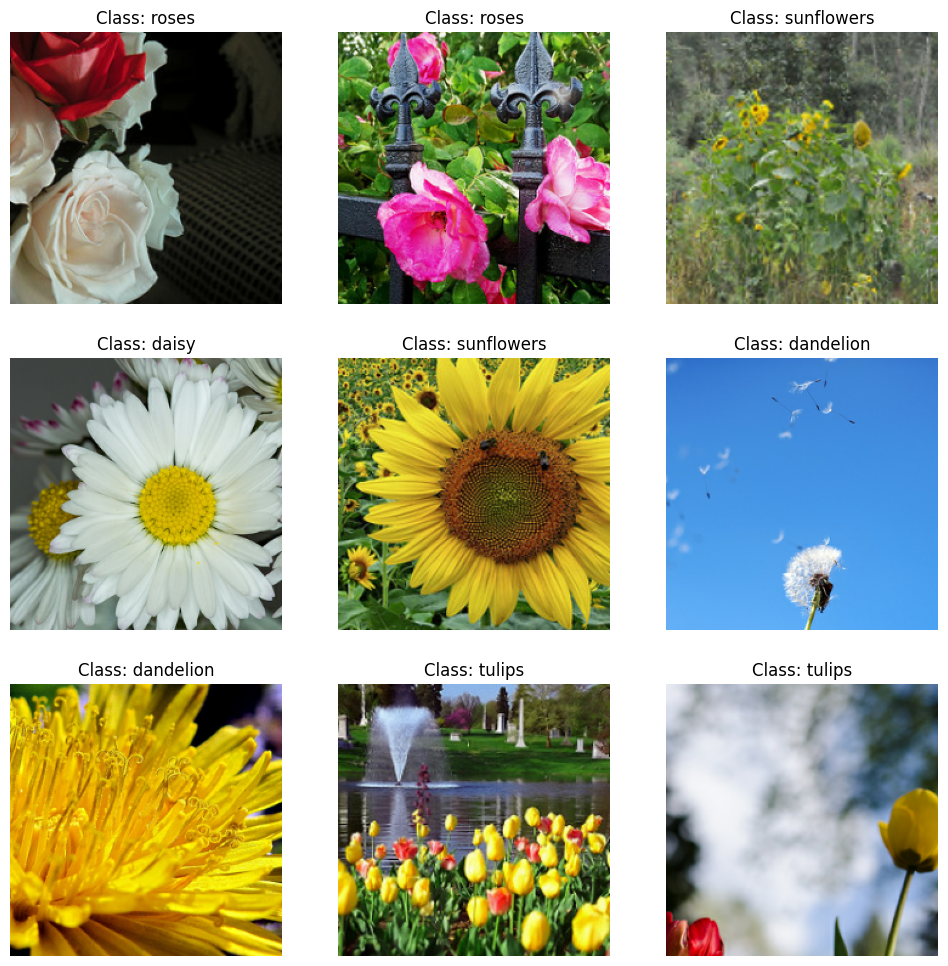

In [100]:
plt.figure(figsize = (12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index +1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
        
plt.show()

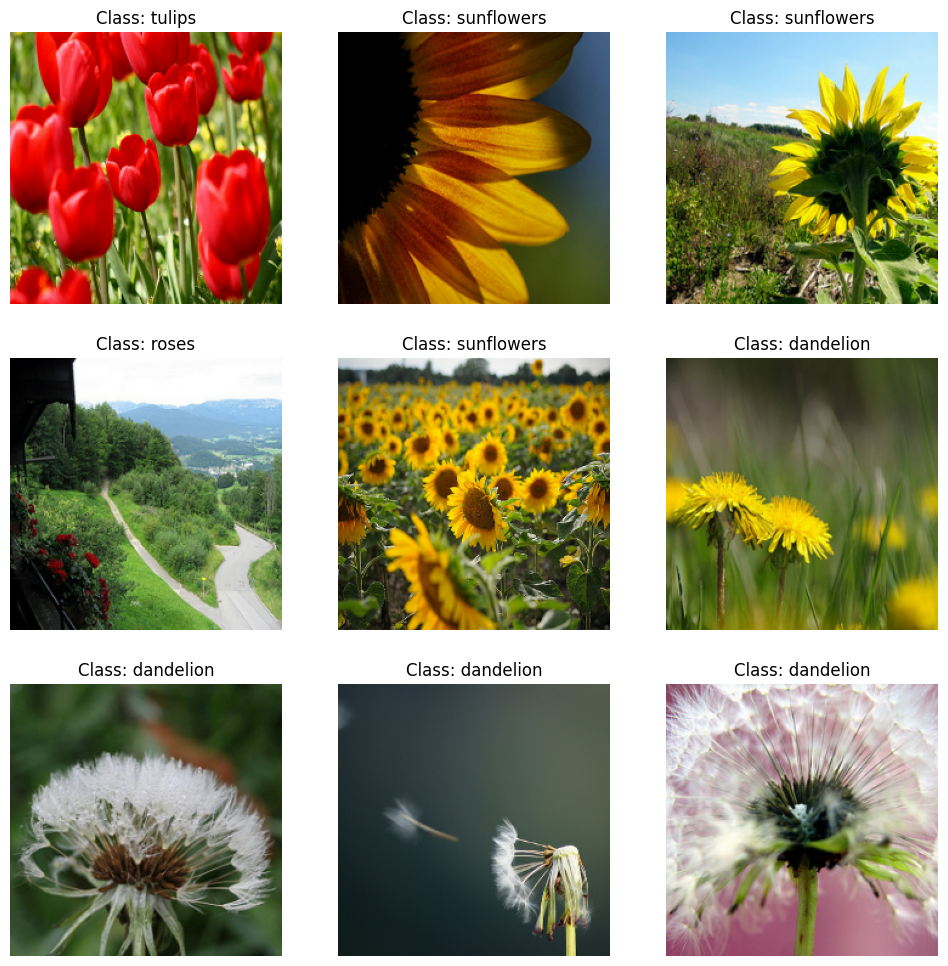

In [101]:

plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
plt.show()

In [103]:
base_model = keras.applications.xception.Xception(weights = 'imagenet',
                                                include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation = "softmax")(avg)
model = keras.models.Model(inputs = base_model.input, outputs = output)

In [104]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_69
13 block2_pool
14 batch_normalization_46
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_70
23 block3_pool
24 batch_normalization_47
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_71
33 block4_pool
34 batch_normalization_48
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [108]:
for layer in base_model.layers:
    layer.trainable = False
    
optimizer = keras.optimizers.SGD(learning_rate = 0.2, momentum = 0.9, decay = 0.01)  # ERROR: weight_decay  -> decay
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
history = model.fit(train_set, 
                    steps_per_epoch = int(0.75*dataset_size / batch_size),
                    validation_data = valid_set,
                    validation_steps = int(0.15*dataset_size / batch_size),
                    epochs = 5)

Epoch 1/5
86/86 [==============================] - 9s 69ms/step - loss: 1.3837 - accuracy: 0.7980 - val_loss: 1.1549 - val_accuracy: 0.8676
Epoch 2/5
86/86 [==============================] - 5s 61ms/step - loss: 0.5774 - accuracy: 0.8979 - val_loss: 0.8666 - val_accuracy: 0.8658
Epoch 3/5
86/86 [==============================] - 5s 61ms/step - loss: 0.3429 - accuracy: 0.9299 - val_loss: 0.8293 - val_accuracy: 0.8585
Epoch 4/5
86/86 [==============================] - 5s 62ms/step - loss: 0.2438 - accuracy: 0.9350 - val_loss: 0.7876 - val_accuracy: 0.8787
Epoch 5/5
86/86 [==============================] - 5s 62ms/step - loss: 0.2049 - accuracy: 0.9455 - val_loss: 0.7668 - val_accuracy: 0.8695


In [110]:
# 모델의 모든 층의 동결 해제, 계속 훈현
# 사전훈련된 가중치가 훼손되지 않도록 훨씬 낮은 학습룰 사용


for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)
     

Epoch 1/40
86/86 [==============================] - 22s 211ms/step - loss: 0.4077 - accuracy: 0.8637 - val_loss: 0.5645 - val_accuracy: 0.8621
Epoch 2/40
86/86 [==============================] - 18s 209ms/step - loss: 0.2992 - accuracy: 0.8993 - val_loss: 0.5211 - val_accuracy: 0.8603
Epoch 3/40
86/86 [==============================] - 18s 207ms/step - loss: 0.2787 - accuracy: 0.9019 - val_loss: 0.5140 - val_accuracy: 0.8566
Epoch 4/40
86/86 [==============================] - 18s 209ms/step - loss: 0.2608 - accuracy: 0.9157 - val_loss: 0.5093 - val_accuracy: 0.8493
Epoch 5/40
86/86 [==============================] - 18s 214ms/step - loss: 0.2803 - accuracy: 0.9044 - val_loss: 0.5006 - val_accuracy: 0.8493
Epoch 6/40
86/86 [==============================] - 18s 215ms/step - loss: 0.2665 - accuracy: 0.9030 - val_loss: 0.5002 - val_accuracy: 0.8456
Epoch 7/40
86/86 [==============================] - 19s 216ms/step - loss: 0.2677 - accuracy: 0.9048 - val_loss: 0.4951 - val_accuracy: 0.8456

### 분류와 위치 추정


In [ ]:
# 물체 중심의 수평, 수직 좌표와 높이, 너비 예측하여 이미지 안에서 물체 주위의 바운딩 박스를 예측
# 4개의 값을 찾을 수 있도록 4개의 유닛을 가진 출력층을 추가, MSE 손실 사용해 훈련
# 훈련 데이터에 바운딩 박스가 표시되어 있지 않으므로 임의의 바운딩 박스를 추가해서 학습 수행

In [114]:
base_model = keras.applications.xception.Xception(weights = 'imagenet',
                                                 include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation = "softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True, decay = True)

model = keras.models.Model(inputs = base_model.input, outputs=[class_output, loc_output])
model.compile(loss = ["sparse_categorical_crossentropy", "mse"], loss_weights = [0.8, 0.2], optimizer = optimizer, metrics = ["accuracy"])

In [115]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [116]:
model.fit(fake_train_set, steps_per_epoch=5, epochs = 2)

Epoch 1/2
5/5 [==============================] - 4s 192ms/step - loss: 1.3341 - dense_7_loss: 1.5737 - dense_8_loss: 0.3758 - dense_7_accuracy: 0.2812 - dense_8_accuracy: 0.2500
Epoch 2/2
5/5 [==============================] - 1s 197ms/step - loss: 1.2456 - dense_7_loss: 1.4920 - dense_8_loss: 0.2601 - dense_7_accuracy: 0.3375 - dense_8_accuracy: 0.2438


### mAP(Mean Average Precision) 

In [ ]:
# mAP는 객체 탐지에서 사용하는 평가 지표
# 평균 정밀도는 최소 n% 재현율에서 달성 가능한 최대 정밀도의 평균, 0<=n<=100
# mAP는 클래스별 평균 정밀도의 평균값

In [117]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

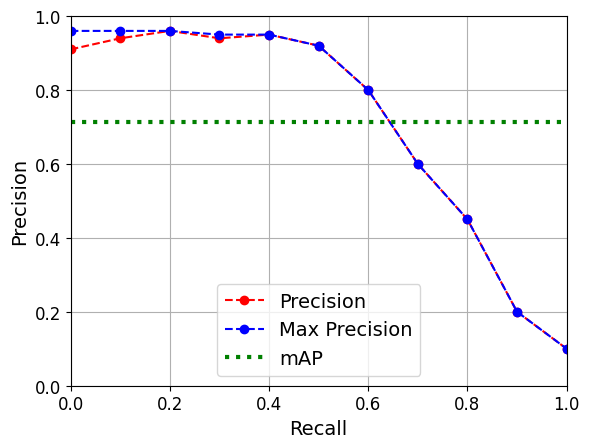

In [120]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]

max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label = "Precision")
plt.plot(recalls, max_precisions, "bo--", label = "Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label = "mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc = "lower center", fontsize = 14)
plt.show()

In [121]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size = 3, strides = 2, padding = "VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

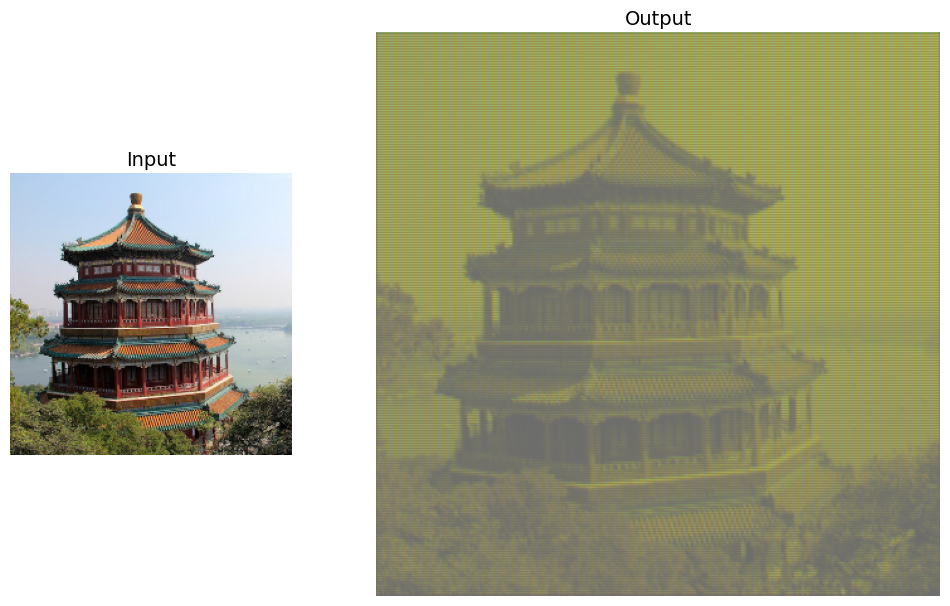

In [127]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize = (12, 8))
gs = mpl.gridspec.GridSpec(nrows = 1, ncols = 2, width_ratios = [1, 2])
ax1 = fig.add_subplot(gs[0, 0])                 
ax1.set_title("Input", fontsize = 14)
ax1.imshow(X[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])                 
ax2.set_title("Output", fontsize = 14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation = "bicubic")
ax2.axis("off")

plt.show()

In [124]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                        (height - 1)*stride + 2*kernel_size -1,
                        (width -1)*stride + 2*kernel_size -1,
                        channels))
    upscaled[:,
            kernel_size - 1:(height -1)*stride + kernel_size:stride,
            kernel_size - 1:(width -1)*stride + kernel_size:stride,
            :] = images
    return upscaled

In [125]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

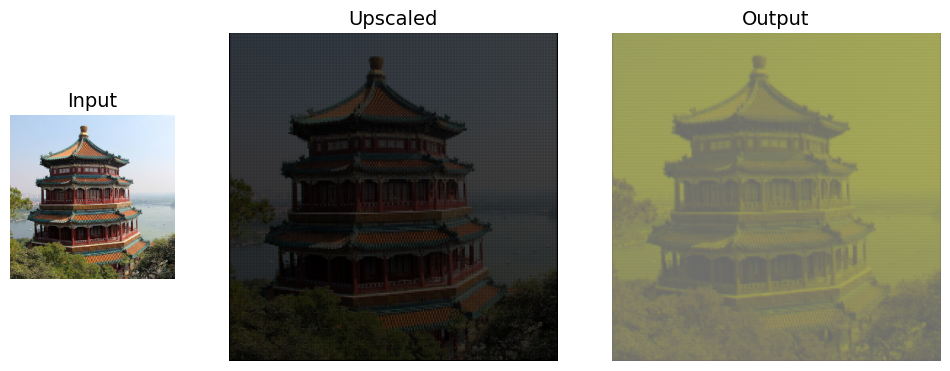

In [128]:

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")
ax3.axis("off")
plt.show()

In [130]:
np.allclose(output, manual_output.numpy(), atol = 1e-7)

# Returns True if two arrays are element-wise equal within a tolerance. The tolerance values are positive, typically very small numbers. 

True